# Interactive tools
> Very helpful interactive tools

In [1]:
# default_exp widgets

In [7]:
# export
import pandas as pd
import numpy as np
from forgebox.df import PandasDisplay
from typing import Callable, List, Tuple, Set, Dict
from ipywidgets import IntSlider, FloatSlider, Text, Textarea, Layout,\
    Output, HBox, VBox, Button, Select, SelectMultiple, Dropdown,\
    IntProgress, HTML

In [8]:
# export
def display_df(df):display(df)

def search_box(df,columns,manual = False,max_rows = 10,callback = display_df):
    """
    create a search box based on dataframe
    df: pandas dataframe
    columns: str, dataframe field name
    manual: bool, search the dataframe on when click the button(manual=True), 
        or on keypress reaction to inputbox (manual=False), default False
    max_rows:int, max rows of show result, default 10
    callback: python callable, discribe the action you want to put on 
        search result (a filtered dataframe), default is to display the dataframe
    """
    from ipywidgets import interact,interact_manual
    from IPython.display import HTML
    
    intera = interact_manual if manual else interact

    @intera
    def search(KeyWord = "",):
        for col in columns:
            result = df[col].fillna("NaN Value").str.contains(KeyWord)
            if sum(result)>0:
                with PandasDisplay(max_colwidth=0,max_rows=max_rows):
                    display(HTML(f"<h3>\"{KeyWord}\" matched on column:[{col}]</h3>"))
                    callback(df[result].head(max_rows))
                    return 
        print(f"Nothing found on any column on keyword:{KeyWord}")
        return 

## Search text within dataframe columns

We can have any dataframe we like:

In [29]:
df = pd.read_csv("~/Downloads/mesh_keywords_202004201804.csv").head(2000)

Put the dataframe and target column names into the ```search_box()```

In [4]:
search_box(df,columns=["keyword",])

interactive(children=(Text(value='', description='KeyWord'), Output()), _dom_classes=('widget-interact',))

If your dataframe is slightly huge, and slow to respond, you can use ```manual=True``` to turn off the auto keypress response

In [5]:
search_box(df,columns=["keyword",],manual=True)

interactive(children=(Text(value='', description='KeyWord'), Button(description='Run Interact', style=ButtonSt…

## Interactive pagination

In [6]:
# export
def paginate(df,page_len = 20):
    """
    Paginate dataframe in jupyter notebook interactively
    Like you can flip through the page
    """
    from ipywidgets import interact,interact_manual
    from IPython.display import display,HTML
    pages = len(df)//page_len
    @interact
    def preview(page = (0,pages)):
        display(HTML(f"<h4>page:{page}/{pages}</4>"))
        end = (page+1)*page_len
        display(df.head(end).tail(page_len))

In [7]:
paginate(df)

interactive(children=(IntSlider(value=50, description='page'), Output()), _dom_classes=('widget-interact',))

## SingleButton widget

A single button widget

It's like interactive_manual with callback

You can make an fully interactive featured widgets if there is only one button to get new page
    
### Example
    
```python
@SingleButton(callback=execute_sql, btn_text:"run command", btn_style="primary")
def makeup_some_sql(
    table={"typing":list, "options":["table_a", "table_b"]},
    limit={"typing":int, "max":1000, "step":10, "default":100},
):
    return f"select * from {table} limit {limit}"
```

In [11]:
# export
def make_hboxes(
    *widgets,
    sections: int=2
) -> List[HBox]:
    """
    Make a list of HBox, with each hbox
        contans {sections} of widgets at most
    widgets: widget from ipywidgets
    sections: int
    """
    hbox_list = []
    hbox_inner=[]
    for idx, widget in enumerate(widgets):
        hbox_inner.append(widget)
        if idx%sections==sections-1:
            hbox_list.append(HBox(hbox_inner))
            hbox_inner=[]
    if len(hbox_inner)>0:
        hbox_list.append(HBox(hbox_inner))
    return hbox_list

class SingleButton:
    """
    A single button widget
    It's like interactive_manual with callback
    
    ## Example
    
    ```python
    @SingleButton(callback=execute_sql, btn_text:"run command", btn_style="primary")
    def makeup_some_sql(
        table={"typing":list, "options":["table_a", "table_b"]},
        limit={"typing":int, "max":1000, "step":10, "default":100},
    ):
        return f"select * from {table} limit {limit}"
    ```
    """
    def __init__(
        self,
        btn_text: str="Run",
        btn_style: str="danger",
        callback: Callable=lambda x:x,
        sections: int=2,
    ):
        """
        btn_text: str, text appears on the button
        btn_style: str, one of the ["danger", "warning", "info", "primary"]
        """
        self.btn_text = btn_text
        self.btn_style = btn_style
        self.callback = callback
        self.sections = sections
        
    def create_slider(
        self, k: str,
        anno: dict):
        """
        create int or float slider widget 
        """
        typing = anno["typing"]
        if typing == int:
            wi = IntSlider(description=k)
        elif typing == float:
            wi = FloatSlider(description=k)
        else:
            raise TypeError(
                f"typing should be either int or float, not {typing}")
        if "default" in anno:
            wi.value = anno["default"]
        if "min" in anno:
            wi.min = anno["min"]
        if "max" in anno:
            wi.max = anno["max"]
        if "step" in anno:
            wi.step = anno["step"]
            
        return wi
    
    def create_text(self, k, anno):
        """
        create text area widget
        """
        if "textarea" in anno:
            layout = Layout(width="100%", height="auto" )
            wi = Textarea(description=k, layout=layout)
        else:
            wi = Text(description=k)
        if "default" in anno:
            wi.value = anno["default"]
        return wi
    
    def create_dropdown(self, k, anno) -> Dropdown:
        atype = anno["typing"]
        wi = Dropdown(description=k, options=anno["options"])
        if "default" in anno:
            wi.value = anno["default"]
        return wi
        
    def anno_widgets(self):
        self.controls = dict()
        for k, anno in self.f.__annotations__.items():
            if "typing" not in anno:
                raise KeyError(f"Missing typing data in arg/kwarg: {k}")
            atype = anno["typing"]
            if atype in [int, float]:
                create_func = self.create_slider
            elif atype == str:
                create_func = self.create_text
            elif atype in [list, tuple, set, dict, List, Tuple, Set, Dict]:
                create_func = self.create_dropdown
            else:
                raise TypeError(f"type {atype} not found")
            self.controls.update({k:create_func(k, anno)})
        
    def execute(self, btn):
        """
        Execute target function
        """
        self.out.clear_output()
        inputs = dict((b.description, b.value) for b in self.controls.values())
        
        with self.out:
            rt = self.target_func(**inputs)
            return rt
        
    def __call__(self, f: Callable):
        """
        Use this class as a decorator
        @SingleButton(callback=func)
        def abc(...):
            ...
        """
        self.f=f
        self.name = f.__name__
        self.anno_widgets()
        def wrapper(*args,**kwargs):
            rt = f(*args,**kwargs)
            self.callback(rt)
            return rt
        
        self.target_func = wrapper
        self.out = Output()
        self.run_btn = Button(
            description=self.btn_text, button_style="danger")
        self.hboxes = make_hboxes(
            *list(self.controls.values()),
            sections=self.sections)
        self.btn_boxes = make_hboxes(self.run_btn, sections=self.sections)
        
        self.run_btn.on_click(self.execute)
        self.vbox = VBox([*self.hboxes, *self.btn_boxes, self.out])
        display(self.vbox)
        return f

### Example for SingleButton

This is a sample callback

In [12]:
from forgebox.html import DOM
def sql_callback(x):
    DOM(x,"h3")()
    # and we execute more code like,
    #    eg. run this line in sql
    return x

Now we can have an interactive single button page, with multipule input widgets

In [13]:
@SingleButton(callback=sql_callback)
def abc(
    limit:{"typing":int, "default":10, "min":5, "max":20},
    where_condition:{"typing":str, "default": "where 1=1", },
    table:{"typing":list, "options":["image_urls","patient_data"]},
):
    return f"sql > SELECT * FROM {table} {where_condition} LIMIT {limit}"

# Dataframe labeler

In [26]:
# export
class Labeler:
    """
    An interactive tool labeling pandas dataframe
        row by row
    """
    def __init__(
        self,
        df: pd.DataFrame,
        options_col: str,
        result_col: str="label",
        show_callback: Callable=None,
        auto_fill_in: bool=True
    ):
        """
        - df: pd.DataFrame, a dataframe prepared
        - options_col: str, column name assigned with options
        - result_col: str, default 'label',
            column name we'll assign the labels
        - auto_fill_in: bool, defult True, do we fill in the label
            automatically if there is only one option
        """
        self.df = df
        self.result_col = result_col
        self.options_col = options_col
        
        if auto_fill_in:
            self.df.loc[:,self.result_col] = self.df[self.options_col]\
                .apply(lambda x:x[0] if len(x)==1 else None)
        else:
            self.df.loc[:,self.result_col] = [None,]*len(self.df)
        
        self.out = Output()
        show_dict = lambda idx,row:str(dict(row))
        self.show_callback = show_dict if show_callback is None else show_callback
        
    def get_progress_bar(self, idx) -> HBox:
        """
        get a progress bar based on the row index
        """
        i = self.df.index.get_loc(idx)
        return HBox([
            IntProgress(value=i, min=0, max=len(self.df)),
            HTML(f"{i+1}/{len(self.df)}")
                    ])
        
    def button_box(
        self,
        idx: int,
        options: List[str]
    ) -> HBox:
        """
        create a box of buttons based on options
        """
        btns = []
        for o in options:
            btn = Button(description = o,)
            btn.value=o
            btn.idx=idx
            btn.on_click(self.choice_cb)
            btns.append(btn)
        return HBox(btns)
        
    def choice_cb(self, option):
        with self.out:
            self.df.loc[option.idx, self.result_col] = option.value
        try:
            idx,row = next(self.gen)
        except StopIteration as e:
            self.out.clear_output()
            display(self.get_progress_bar(self.df.index[-1]))
            display(HTML("<h3>All Done</h3>"))
            display(HTML("<h5>Thanks for all the labeling, now try self.df to see the result</h5>"))
            return
        self.show_func(idx,row)
        
    def __iter__(self):
        for idx, row in self.df.iterrows():
            if (row[self.result_col] is None) and (len(row[self.options_col]))>1:
                yield idx, row
        
    def __call__(self) -> None:
        """
        Start labeling
        """
        self.gen = iter(self)
        self.show_func(*next(self.gen))
        display(self.out)
    
    def show_func(self, idx, row) -> None:
        self.out.clear_output()
        with self.out:
            display(
                    VBox([
                        self.get_progress_bar(idx),
                        HTML(self.show_callback(idx, row)),
                        self.button_box(idx, row[self.options_col])
                    ]))

In [30]:
df = df.loc[1:].reset_index(drop=True)
df.head()

,keyword
0,Appetite Regulation
1,Hymecromone
2,Round Ligament of Uterus
3,Sugar Acids
4,Nogalamycin


### Design a dataframe with a column assigned with options

In [32]:
df.loc[:,"length"] = df.keyword.apply(len)
df["options"] = pd.Series([["A","B"]]*len(df))
df

,keyword,length,options
0,Appetite Regulation,19,"[A, B]"
1,Hymecromone,11,"[A, B]"
2,Round Ligament of Uterus,24,"[A, B]"
3,Sugar Acids,11,"[A, B]"
4,Nogalamycin,11,"[A, B]"
...,...,...,...
1994,Alcoholics Anonymous,20,"[A, B]"
1995,Lymphocyte Cooperation,22,"[A, B]"
1996,Anthocerotophyta,16,"[A, B]"
1997,Traction,8,"[A, B]"


In [34]:
def show_keyword(idx: int, row: Dict[str, str]):
    kw = row["keyword"]
    length = row["length"]
    return f"""
    <div>Keyword
    <strong class='text-danger'>{kw}</strong>
    (with length:{length})
    </div>"""

lbl = Labeler(df, options_col="options", show_callback=show_keyword)

### Start labeling 

In [ ]:
lbl()

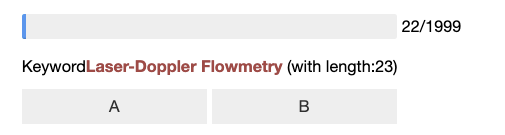

### Review the label result

In [38]:
lbl.df.head()

,keyword,length,options,label
0,Appetite Regulation,19,"[A, B]",A
1,Hymecromone,11,"[A, B]",B
2,Round Ligament of Uterus,24,"[A, B]",A
3,Sugar Acids,11,"[A, B]",B
4,Nogalamycin,11,"[A, B]",B
